<a href="https://colab.research.google.com/github/sushi057/HOML3/blob/main/micrograd_from_scratch_ez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [254]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [255]:
def f(x):
  return 3*x**2 - 4*x + 5

In [256]:
f(3.0)

20.0

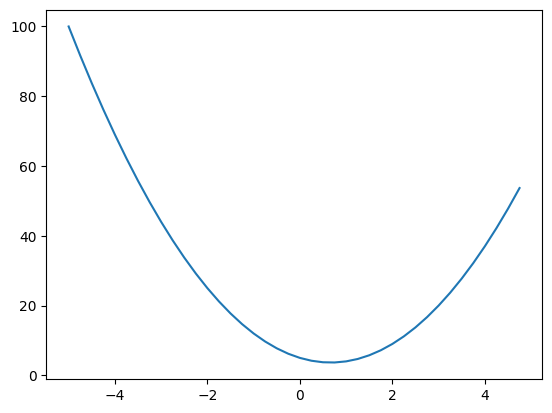

In [257]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [258]:
h = 0.000001
x = -3.0

(f(x+h) - f(x))/h

-21.999997002808414

In [259]:
class Value:
  def __init__(self, data, _children=(), _op="", label="", grad=0.0):
    self.data = data
    self._prev = _children
    self._backward = lambda:None
    self._op = _op
    self.label = label
    self.grad = grad

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __neg__(self):
    return self * -1


  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other ** -1

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only using int/float"
    out = Value(self.data ** other, (self, ), f'**{other}')

    def _backward():
      self.grad = other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), "exp")

    def _backward():
      self.grad = (out.data) * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), "tanh")

    def _backward():
      self.grad += (1 - t ** 2) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [260]:
a = Value(4.0)
b = Value(2.0)
a-b

Value(data=2.0)

Gradients are initalized at 0.0 and they accumulate when backward propagation is done.

In [261]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## Backpropagation with a Neuron

In [262]:
#input values
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

#weight values
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

#bias of neuron
b = Value(6.8813735870915432, label="b")

#x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "E(xw)"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"
o.backward()

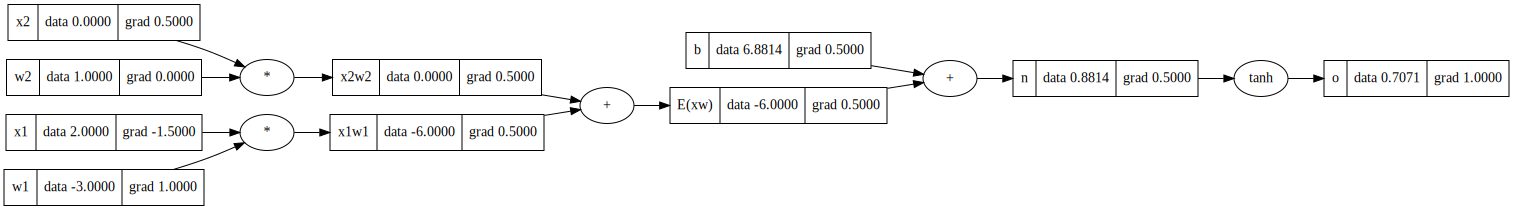

In [263]:
draw_dot(o)

We decide the level of complexity for our backpropgation implementation.

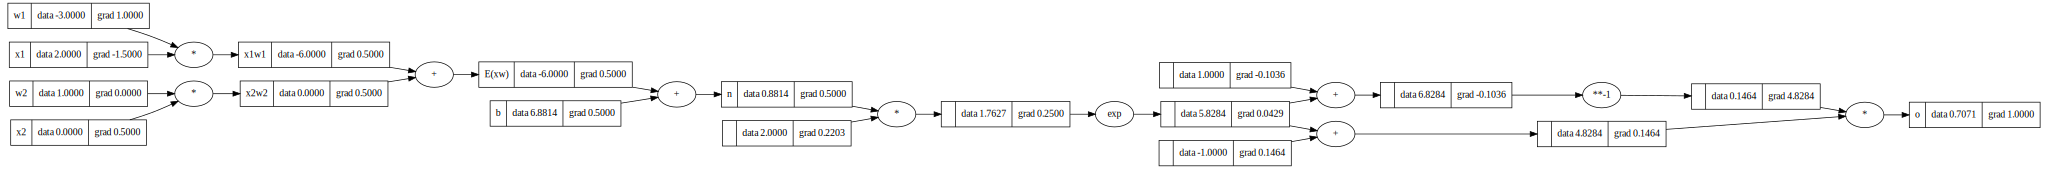

In [264]:
#input values
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

#weight values
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

#bias of neuron
b = Value(6.8813735870915432, label="b")

#x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "E(xw)"
n = x1w1x2w2 + b; n.label = "n"
# ------
e = (2*n).exp()
o = (e-1)/(e+1)
# -------
o.label = "o"
o.backward()
draw_dot(o)

### Making the same thing in Pytorch

In [265]:
import torch
import random

In [266]:
x1 = torch.Tensor([2.0]).double()   ;x1.requires_grad=True
x2 = torch.Tensor([0.0]).double()   ;x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double()  ;w1.requires_grad=True
w2 = torch.Tensor([1.0]).double()   ;w2.requires_grad=True
b = torch.Tensor([6.8813735870915432]).double() ;b.require_grad=True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## Neural Networks

In [267]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, 1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7671028068735684)

### Implementing Loss Function

In [268]:
xs = [[2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, 1.0, -1.0],
      ]

ys = [1.0, -1.0, -1.0, 1.0]

### Iteration Loop

In [269]:
for k in range(50):

  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yp - ytrue)**2 for yp, ytrue in zip(ypred, ys)])
  loss

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.07 * p.grad

  if k % 10 == 0:
    print(k, loss)

0 Value(data=4.7484927415930756)
10 Value(data=0.045561933999106644)
20 Value(data=0.02191879740488635)
30 Value(data=0.014370085799317457)
40 Value(data=0.010679222049790577)


In [270]:
ypred

[Value(data=0.9531722244446318),
 Value(data=-0.9748482790068275),
 Value(data=-0.9493908896787224),
 Value(data=0.9426765463959434)]

#### Neural Networks made from scratch.